## Whole Genome Sequenced Mycobacterium bovis analysis for BTBgenie.

Note: the current version of the M.bovis genome online has genes missing in the annotation. See https://www.ncbi.nlm.nih.gov/nuccore/LT708304.1?report=graph

Updated files can be found here: https://github.com/dmnfarrell/gordon-group/tree/master/mbovis_annotation

links:

* https://github.com/JosephCrispell/GeneralTools/tree/master/ProcessingPipeline
* [Woodchester Park eLife paper](https://elifesciences.org/articles/45833)
* http://www.htslib.org/doc/bcftools.html
* https://mtbgenomicsworkshop.readthedocs.io/
* [BCFtools cheat sheet](https://gist.github.com/elowy01/93922762e131d7abd3c7e8e166a74a0b)
* https://pypi.org/project/pyfaidx/
* https://biopython.org/wiki/Category:Cookbook
* https://pyvcf.readthedocs.io/en/v0.4.6/INTRO.html

In [1]:
import sys,os,shutil,subprocess
import random
import glob, time
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from gzip import open as gzopen
sys.path.append('pathogenie')
from pathogenie import tools, aligners, app, trees

## test set of Mbovis samples

In [2]:
sra = pd.read_csv('../sra_mbovis_runtable.csv')
#sra.geo_loc_name_country.value_counts()
sub=sra[(sra.geo_loc_name_country=='Ireland') & (sra.Host=='COW') ]
cols = ['Run','geo_loc_name_country','DATASTORE filetype','LibraryLayout','Host','ReleaseDate','Bytes']
print (sub[cols])


              Run geo_loc_name_country DATASTORE filetype LibraryLayout Host           ReleaseDate        Bytes
4405  SRR10482932              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  252763749.0
4406  SRR10482933              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  226451145.0
4407  SRR10482934              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  200402392.0
4408  SRR10482935              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  158908297.0
4409  SRR10482936              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  253008968.0
4413  SRR10482941              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  241530862.0
4415  SRR10482943              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  251394652.0
4417  SRR10482945              Ireland          fastq,sra        PAIRED  COW  2019-12-11T00:00:00Z  2468

In [ ]:
# fetch from SRA
def fetch_sra_reads(df):
    #download a subset of reads
    path = '/storage/btbgenie/mbovis_sra'
    for i,r in df.iterrows():        
        files = glob.glob(os.path.join(path,r.Run+'*'))        
        if len(files)==0:
            cmd = 'fastq-dump --split-3 {n} --outdir {o}'.format(n=r.Run,o=path)
            print (cmd)
            subprocess.check_output(cmd,shell=True)
        
fetch_sra_reads(sub[8:9])

## Blasting to known contaminants

* https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-2684-x#Sec2

In [3]:
#get unmapped reads from a bam file

infile='mapped/3_S57_L001.bam'
cmd = 'samtools view -b -f 4 {i} > unmapped.bam'.format(i=infile)
print (cmd)
#align with bwa to known index of contaminants


samtools view -b -f 4 mapped/3_S57_L001.bam > unmapped.bam


### Examine FASTQ file quality and define trimming parameters

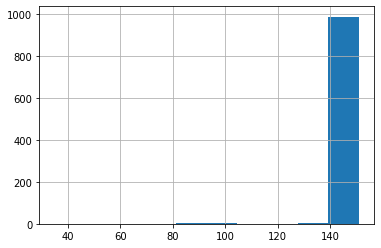

In [4]:
reload(tools)

df = tools.fastq_to_dataframe(testfile)
df.length.hist()

43.92692995071411


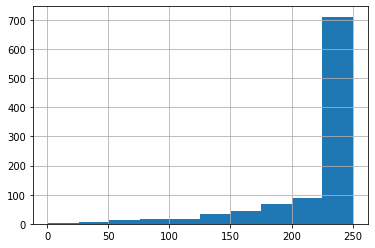

In [4]:
def trim_reads_default(filename, outfile, right_quality=30):
    """Trim adapters"""
        
    fastq_parser = SeqIO.parse(gzopen(filename, "rt"), "fastq")
    c=0
    out = gzopen(outfile, "wt")
    for record in fastq_parser:
        score = record.letter_annotations["phred_quality"]         
        for i in range(len(score)-1,0,-1):
            if score[i] >= right_quality:
                break
        #trimmed.append(record[:i])
        #print (record[:i])        
        #c+=1
        #if c>100:
        #    break    
        SeqIO.write(record[:i],out,'fastq')
    return

testfile = 'mbovis_sra/SRR1791711_1.fastq.gz'
st=time.time()
trim_reads_default(testfile,'trimmed.fastq.gz')
print (time.time()-st)
df = tools.fastq_to_dataframe('trimmed.fastq.gz')
df.length.hist()

### multiprocess trimming

In [439]:
def split_fastq(filename, chunks=4):
    """Split fastq file"""
    
    names=[]
    tmp = '/tmp'
    tmpfiles = []
    record_iter = SeqIO.parse(gzopen(filename, "rt"), "fastq")
    length = 
    for i, batch in enumerate(tools.batch_iterator(record_iter, chunksize)):
        tempfile = "group_%i.fastq" % (i + 1)
        tmpfiles.append(tempfile)
        names.append(tempfile)
        with open(tempfile, "w") as handle:
            count = SeqIO.write(batch, handle, "fastq")
        print("Wrote %i records to %s" % (count, tempfile))
    return names

split_fastq(testfile)

Wrote 465388 records to group_1.fastq


['group_1.fastq']

In [ ]:
tools.plot_fastq_qualities(testfile,limit=100000)
plt.savefig('fastq_quals.png',dpi=100)
tools.plot_fastq_gc_content(testfile, limit=50000)
plt.savefig('gc.png',dpi=100)

### Get sample ids from fastq files

In [ ]:
path1='albania'
files = glob.glob(os.path.join(path1,'*.fastq.gz'))
#path2='/storage/btbgenie/mbovis_sra'
path2='mbovis_sra'
files = glob.glob(os.path.join(path2,'*.fastq.gz'))

files = app.get_files_from_paths([path1,path2])

df = app.get_samples(files)
df
#df.set_index(['sample','pair']).unstack()


In [56]:
#tab file for multi snippy
x = df.reset_index().pivot(columns='pair', index='sample', values='filename')
x.to_csv('samples.tab',sep='\t')

### Align the FASTQ files against reference and create VCF files

In [ ]:
reload(aligners)
ref = app.ref_genome
samples = get_samples(files)

app.align_reads(samples, idx=ref, threads=10, overwrite=False)

In [16]:
def get_samples():
    import vcf
    vcf_reader = vcf.Reader(open('mapped/calls.vcf.gz', 'rb'))
    vcf_reader.samples

### remove duplicated reads

In [ ]:
cmd = 'samtools rmdup A_reads.bt2.sorted.bam A_reads.bt2.sorted.noDups.bam'

### call all samples at once

In [46]:
def variant_calling(bam_files, ref, outpath, sample_file=None, threads=4,
                    callback=None, overwrite=False, **kwargs):
    """Call variants with bcftools"""

    #bam_files = ' '.join(bam_files)
    rawbcf = os.path.join(outpath,'raw.bcf')
    #cmd = 'bcftools mpileup -O b -o {o} -f {r} {b}'.format(r=ref, b=bam_files, o=rawbcf)
    #run mpileup in parallel to speed up    

    if not os.path.exists(rawbcf) or overwrite == True:
        #rawbcf = mpileup_multiprocess(bam_files, ref, outpath, threads=threads, callback=callback)
        rawbcf = mpileup_gnuparallel(bam_files, ref, outpath, threads=threads, callback=callback)

    #find snps
    vcfout = os.path.join(outpath,'calls.vcf')
    cmd = 'bcftools call -V indels --ploidy 1 -m -v -o {v} {raw}'.format(v=vcfout,raw=rawbcf)
    if callback != None:
        callback(cmd)
    print (cmd)
    subprocess.check_output(cmd,shell=True)
    #rename samples
    if sample_file != None:
        cmd = 'bcftools reheader --samples {s} -o {v} {v}'.format(v=vcfout,s=sample_file)
        print(cmd)
        tmp = subprocess.check_output(cmd,shell=True)
    final = os.path.join(outpath,'filtered')
    
    cmd = 'bcftools filter -e "QUAL<40" -o {o}.vcf.gz -O z {i}'.format(i=vcfout,o=final)
    print (cmd)
    tmp = subprocess.check_output(cmd,shell=True)
    if callback != None:
        callback(tmp)        
    return final

def create_bam_labels(filenames):
    
    names = [os.path.basename(i).split('.')[0] for i in filenames]
    #print (names)
    with open('samples.txt','w+') as file:
        for s in zip(bam_files,names):
            file.write('%s %s\n' %(s[0],s[1]))
    return

bam_files = glob.glob('mapped/*.bam')
create_bam_labels(bam_files)
vcf_file = variant_calling(bam_files, ref, 'mapped', threads=10, overwrite=False)#, sample_file='samples.txt')


bcftools call -V indels --ploidy 1 -m -v -o mapped/calls.vcf mapped/raw.bcf
bcftools filter -e "QUAL<40" -o mapped/filtered.vcf.gz -O z mapped/calls.vcf


In [209]:
v1 = vcf_to_dataframe('result.vcf')
print (v1.var_type.value_counts())

unknown    4342195
indel        10772
snp           7545
Name: var_type, dtype: int64

In [12]:
v2 = vcf_to_dataframe('mapped/raw.vcf')
print (v2.var_type.value_counts())

unknown    4342195
indel        10772
snp           7545
Name: var_type, dtype: int64


In [ ]:
cmd = 'bcftools filter -e "QUAL<40" -o filtered.vcf.gz mapped/calls.vcf'
print (cmd)
#tmp = subprocess.check_output(cmd,shell=True)

In [8]:
def vcf_to_dataframe(vcf_file, quality=30):
    """Convert vcf to dataframe"""

    import vcf
    ext = os.path.splitext(vcf_file)[1]    
    if ext == '.gz':
        file = gzopen(vcf_file, "rt")
    else:
        file = open(vcf_file)
    vcf_reader = vcf.Reader(file,'r')    
    res=[]
    cols = ['chrom','var_type','sub_type','start','end','REF','ALT','QUAL','DP']
    i=0
    for rec in vcf_reader:
        #if i>10:
        #    break
        x = [rec.CHROM, rec.var_type, rec.var_subtype, rec.start, rec.end, rec.REF, str(rec.ALT[0]),
            rec.QUAL, rec.INFO['DP']]
        #print (rec.__dict__)
        #print (rec.INFO.keys())
        #for call in rec.samples:
        #    print (call.sample, call.data, rec.genotype(call.sample)) 
        res.append(x)
        #print (x)    
        #i+=1
    res = pd.DataFrame(res,columns=cols)    
    return res


In [47]:
vdf = vcf_to_dataframe('mapped/filtered.vcf.gz')
vdf.var_type.value_counts()

snp    2756
Name: var_type, dtype: int64

### Make fasta alignment from filtered VCF sites with multiple samples

https://github.com/JosephCrispell/GeneralTools/blob/master/ProcessingPipeline/CreateFastaWithReferenceFromFiltered_28-06-17.pl

"The allele frequencies at each position in the aligned (against reference) sequence from each isolate were examined. For a haploid organism these frequencies are expected to be either 0 or 1, with some random variation expected from sequencing errors (Sobkowiak et al., 2018). A heterozygous site was defined as one where the allele frequencies were >0.05 and <0.95. Four cattle-derived sequences that had more than 150 heterozygous sites, and allele frequencies that were clustered and non-random (data not shown), were removed. In addition, 26 badger-derived and 16 cattle-derived M. bovis sequences were removed because of suspected errors in the metadata (Appendix 1: Investigating isolate metadata discrepancies).

For the sequences from the remaining isolates (204 badger- and 169 cattle-derived isolates), alleles were called at each variant position if they had mapping quality ≥30, high-quality base depth ≥4 (applied to reverse and forward reads separately), read depth ≥30, and allele support ≥0.95. For any site that failed these criteria, if the allele called had been observed in a different isolate that had passed, a second round of filtering was conducted using a high-quality base depth of 5 (total across forward and reverse reads) and the same allele support. As recombination is thought to be extremely rare for mycobacteria (Namouchi et al., 2012), variants in close proximity could indicate a region that is difficult to sequence or under high selection. To avoid calling variants in these regions, variant positions within 10 bp of one another were removed. Following filtering, sequences from 11 badger and 10 cattle isolates that had insufficient coverage (<95%) of the variant positions were removed. Once the alignment was generated, sites with a consistency index less than 1, generally considered homoplasies (Farris, 1989), were removed (n = 4, of 14,991 sites) using HomoplasyFinder (v0.0.0.9; Crispell et al., 2019; RRID: SCR_017300). All the scripts necessary for the processing of the WGS data are freely available online."

In [48]:
def fasta_alignment_from_vcf(vcf_file, ref, callback=None):
    """Get a fasta alignment for all snp sites in a multi sample
    vcf file, including the reference sequence"""
    
    from pyfaidx import Fasta
    from pyfaidx import FastaVariant
    #index vcf
    cmd = 'tabix -p vcf -f {i}'.format(i=vcf_file)
    tmp = subprocess.check_output(cmd,shell=True)
    #get samples?
    import vcf
    vcf_reader = vcf.Reader(open(vcf_file, 'rb'))
    samples = vcf_reader.samples
    print ('%s samples' %len(samples))
    result = []
    
    #reference sequence
    reference = Fasta(ref)
    chrom = list(reference.keys())[0]

    #get the set of all sites first
    sites=[]
    for sample in samples:
        #print (sample)
        variant = FastaVariant(ref, vcf_file, 
                                 sample=sample, het=True, hom=True)
        pos = list(variant[chrom].variant_sites)
        sites.extend(pos)
        #print (sample)
        #print (pos[:20])
    sites = sorted(set(sites))
    n=550
    #sites=sites[:n]
    print ('using %s sites' %len(sites))
    if callback != None:
        callback('using %s sites' %len(sites))
    #get reference sequence for site positions
    refseq=[]
    for p in sites:
        refseq.append(reference[chrom][p-1].seq)
    refseq = ''.join(refseq)
    #print (refseq)
    refrec = SeqRecord(Seq(refseq),id='ref')
    result.append(refrec) 

    #iterate over variants in each sample
    for sample in samples:        
        seq=[]
        variant = FastaVariant(ref, vcf_file, 
                                 sample=sample, het=True, hom=True)     
        #for p in variant[chrom].variant_sites:
        for p in sites:        
            rec = variant[chrom][p-1:p]
            #print (p,rec)
            seq.append(rec.seq)
        seq = ''.join(seq)
        #print (seq)
        seqrec = SeqRecord(Seq(seq),id=sample)
        result.append(seqrec)    
    return result

st=time.time()
result = fasta_alignment_from_vcf('mapped/filtered.vcf.gz', app.ref_genome)
SeqIO.write(result, 'variants.fa', 'fasta')
print (time.time()-st)

6 samples
using 2756 sites
5.6892006397247314


### Phylogeny from MSA

In [49]:
def run_RAXML(infile, name='variants', threads=8):
    """Run Raxml pthreads"""

    bootstraps = 10 
    model = 'GTRCAT'
    s1 = random.randint(0,1e8)
    s2 = random.randint(0,1e8)
    
    files = glob.glob('RAxML_*')
    for f in files:
        os.remove(f)
    cmd = 'raxmlHPC-PTHREADS -f a -N {nb} -T {t} -m {m} -V -p {s1} -x {s2} -n {n} -s {i}'.format(t=threads,nb=bootstraps,n=name,i=infile,s1=s1,s2=s2,m=model)
    print (cmd)
    tmp = subprocess.check_output(cmd, shell=True)
    return
    
run_RAXML('variants.fa')

raxmlHPC-PTHREADS -f a -N 10 -T 8 -m GTRCAT -V -p 81287182 -x 18745047 -n variants -s variants.fa


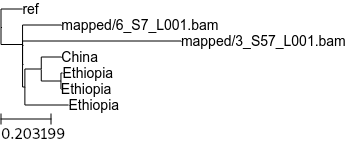

In [50]:
def create_tree(filename, labelmap=None):
    """Draw a tree """
    
    from ete3 import Tree, NodeStyle, TreeStyle
    t = Tree(filename)
    t.set_outgroup('ref')    
    if labelmap != None:
        trees.set_tiplabels(t,labelmap)
    trees.format_nodes(t)
    ts = TreeStyle()
    ts.scale=1000
    t.render("%%inline", tree_style=ts)
    t.render("tree.png", tree_style=ts)
    return t

sra['filename'] = sra.Run.apply(lambda x: 'mapped/'+x+'.bam')
#print (sra[:3])
labelmap = dict(zip(sra.filename,sra.geo_loc_name_country))
#print (labelmap)
t = create_tree('RAxML_bipartitions.variants', labelmap)
t.render("%%inline")

In [ ]:
from Bio import Phylo
tree=Phylo.read('RAxML_bestTree.variants','newick')
Phylo.draw(tree)

### Consequence calling

In [ ]:
cmd = 'bcftools csq -f Mbovis_AF212297.fa -g  Mbovis_csq_format.gff col2_mbovis.vcf -Ot -o col2_mbovis.csq.tsv'